In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import copy
import time

plt.gray()

<Figure size 432x288 with 0 Axes>

## FUNCTIONS

In [4]:
# Get the difference of two images, uncomment to print the values and show imgs
def gray_SAD(left,right):
    diff = np.abs(left.astype(int)-right.astype(int))
    sum = np.sum(diff)
    # print("Nose_left-nose3 = ", sum)
    # f, (ax_left, ax_middle, ax_right) = plt.subplots(1, 3, figsize=(18,18))
    # ax_left.imshow(left)
    # ax_middle.imshow(diff)
    # ax_right.imshow(right)
    return sum

# Solve the Intermediate step 3, finding the best fit within only one row in image
def SAD_linescan(pattern,row):
    correlation = []
    for i in range(0,row.shape[1]-pattern.shape[1]):
        row_crop = row[:,i:i+pattern.shape[1]]
        # f, (ax_left, ax_middle, ax_right) = plt.subplots(1, 3, figsize=(18,18))
        # ax_left.imshow(pattern)
        # ax_middle.imshow(row_crop)
        # ax_right.imshow(row)
        correlation.append(gray_SAD(pattern,row_crop))
    return np.argmin(correlation)

# look at the m x m matrix around an take the max value
def max_filter(row,col,m,disparity2D):
    values = []
    for x in range(-int(m/2),int(m/2)):
        for y in range(-int(m/2),int(m/2)):
            values.append(disparity2D[row+x][col+y])
    return min(values)



Implementation of stereo block matching


This week you'll be implementing your own block matching algorithm for stereo depth reconstruction. Thus you are not allowed to use cv2.matchTemplate, cv2.stereoBM or similar functions from opencv or other pre-existing libraries. You can find all necessary image-files in the attached zip-file.

It is recommended you use the following three intermediate steps before going directly to a full implementation:

Intermediate step 1:


Implement a function that takes two equal size images and calculates the sum of absolute differences. The two equal-sized images are nose_left.png (used as the template) and nose_right.png.

Intermediate step 2:


Using the function you just created, find which of the three images nose1.png, nose2.png, nose3.png gives the best match to nose_left.png?

Intermediate step 3:


Since these images are rectified, we can approximately assume that a pixel found in row x in the left image also lives in row x in the right image. nose_span.png contains the entire row containing the nose of the sculpture. The height of the span is 7 - the same height as your template. Write a function that loops through the image from left to right and computes the correlation using your function from step 1 to find where in the span the nose is located.

## INTERMEDIATE STEP 1+2
* we get the best diff result for nose_left - nose2

1490

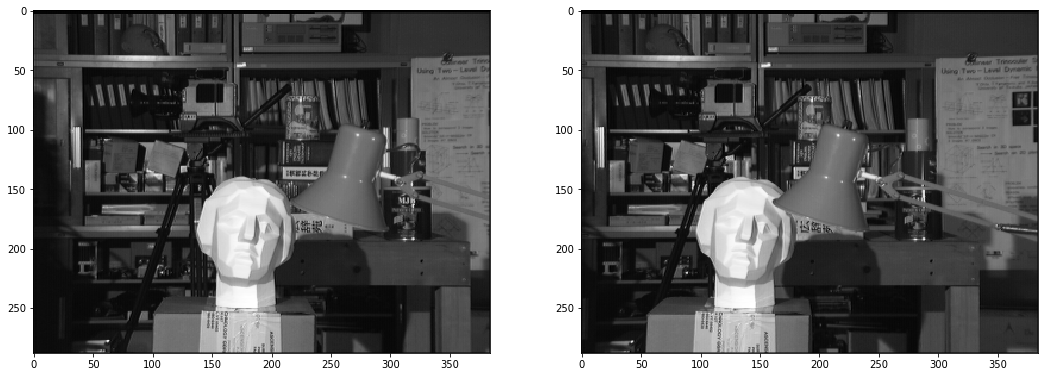

In [143]:
# load the images
img_left = cv2.imread("tsukuba_left.png")
img_right = cv2.imread("tsukuba_right.png")
nose_left = cv2.imread("nose_left.png")
nose_right = cv2.imread("nose_right.png")
nose1 = cv2.imread("nose1.png")
nose2 = cv2.imread("nose2.png")
nose3 = cv2.imread("nose3.png")

# convert images to grayscale for template matching
img_left_gray = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
img_right_gray = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
nose_left_gray = cv2.cvtColor(nose_left, cv2.COLOR_BGR2GRAY)
nose_right_gray = cv2.cvtColor(nose_right, cv2.COLOR_BGR2GRAY)
nose1_gray = cv2.cvtColor(nose1, cv2.COLOR_BGR2GRAY)
nose2_gray = cv2.cvtColor(nose2, cv2.COLOR_BGR2GRAY)
nose3_gray = cv2.cvtColor(nose3, cv2.COLOR_BGR2GRAY)

f, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(18,18))
ax_left.imshow(img_left_gray)
ax_right.imshow(img_right_gray)

# uncomment the section in function to print the results
gray_SAD(nose_left_gray,nose_right_gray)
gray_SAD(nose_left_gray,nose1_gray)
gray_SAD(nose_left_gray,nose2_gray)
gray_SAD(nose_left_gray,nose3_gray)

## INTERMEDIATE STEP 3

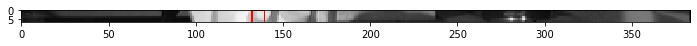

In [144]:
# load the images
nose = cv2.imread("nose2.png")
nose_span = cv2.imread("nose_span.png")

# convert images to grayscale for template matching
nose_gray = cv2.cvtColor(nose, cv2.COLOR_BGR2GRAY)
nose_span_gray = cv2.cvtColor(nose_span, cv2.COLOR_BGR2GRAY)

# running the algorithm
min_index = SAD_linescan(nose_gray,nose_span_gray)
nose_final = cv2.rectangle(nose_span.copy(), (min_index, 0), (min_index+nose_gray.shape[1], nose_gray.shape[1]), (255,0,0), 1)
plt.figure(figsize=(12,12))
plt.imshow(nose_final)


Full template matching implementation (Challenge):


Write a template matching function that iteratively takes a 7x7 subpart (numpy calls this slicing) of tsukuba_left.png and uses your function from step 3 to apply it to the corresponding row in tsukuba_right.png and stores the lowest/best matching disparity value for that template. Continue until all possible templates for a row has been used before moving down to the next row in the image.

## CHALLENGE

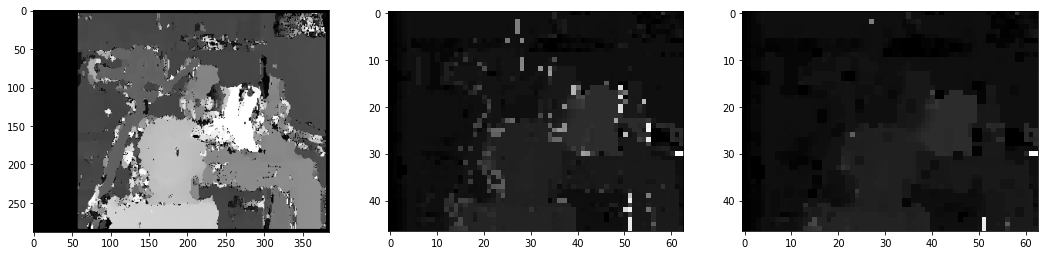

In [10]:
# load the images
left = cv2.imread("tsukuba_left.png")
right = cv2.imread("tsukuba_right.png")

# convert images to grayscale for template matching
left_gray = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)

# adjust size of the square
n = 6 # SVD kernel
m = 3 # max filter kernel

# running the algorithm
disparity2D = []
for row in range(0,left.shape[0]-n,n):
    disparity1D = []
    for col in range(0,left.shape[1]-n,n):
        pattern = left[row:row+n,col:col+n]
        image_crop = right[row:row+n,0:col+n+1] # Only need to scan to the left when looking with the right eye
        disparity = abs(col-SAD_linescan(pattern,image_crop))
        disparity1D.append(disparity)
    disparity2D.append(disparity1D)

# reducing the noise
disparity2D_new = copy.deepcopy(disparity2D)
for row in range(m,len(disparity2D)-m):
    for col in range(m,len(disparity2D[0])-m):
        disparity2D_new[row][col] = max_filter(row,col,m,disparity2D)

# function from exercises
min_disp = 7 # 7
num_disp = 3*16 # 3*16
block_size = 9 # 5, 11
stereo = cv2.StereoBM_create(numDisparities = num_disp, blockSize = block_size)
stereo.setMinDisparity(min_disp)
stereo.setDisp12MaxDiff(200) # 200
stereo.setUniquenessRatio(1) # 1
stereo.setSpeckleRange(10) # 3
stereo.setSpeckleWindowSize(1) # 3
disp = stereo.compute(left_gray, right_gray).astype(np.float32) / 16.0

# ploting
f, (ax_left, ax_middle, ax_right) = plt.subplots(1, 3, figsize=(18,18))
ax_left.imshow(disp)
ax_middle.imshow(disparity2D)
ax_right.imshow(disparity2D_new)